# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable

## Authors
- Nicholas Sistovaris
- Moritz Geiger
- Pravalika Myneni
- Sowmya Madala

## External links and resources

All the external data or resources that was not provided by the WDL was acquired through the following links:

1. https://noise-planet.org/noisemodelling.html 
2. https://www.torinocitylab.it/en/asset-to/open-data 
3. https://www.officeholidays.com/countries/italy/turin/2018 
4. https://www.feiertagskalender.ch/index.php?geo=3815&jahr=2018&hl=en
5. http://webgis.arpa.piemonte.it/basicviewer_arpa_webapp/index.html?webmap=89aa175451d24ae0a1911e67957d9aec
6. http://aperto.comune.torino.it/dataset/zone-statistiche
7. https://openweathermap.org/history
8. https://developers.google.com/maps/documentation/places/web-service/details 
9. https://www.cirrusresearch.co.uk/blog/2013/01/noise-data-averaging-how-do-i-average-noise-measurements/

## Introduction

**Overview:**


_from challenge description_
<blockquote>

</blockquote>



**Research:**



## Development
Start coding here! 👩‍💻

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

In [24]:
!pip install geopandas
!pip install pmdarima

### Imports (libraries) 📚

In [2]:
## TABULAR
import pandas as pd 
import numpy as np
import matplotlib

## GEO
import geopandas as gpd
import fiona
import folium
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.map import LayerControl, Layer, FeatureGroup
from folium.vector_layers import Circle, CircleMarker
from shapely.geometry import LineString, Point
from shapely import wkt


## DATA
import os
import zipfile
from collections import Counter
import re
from datetime import datetime
import requests
#from dotenv import load_dotenv, find_dotenv
import ast
import datetime as dt
from io import StringIO, BytesIO


## VIS
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa
import branca
import plotly.express as px
import matplotlib.patches as patches

## Feature Selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.datasets import load_digits

## TIME SERIES
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima 


## MODELLING
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.model_selection import train_test_split 

# NEURAL NETWORKS
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Importing Dataframes

Following a first glance at the dataframes provided by the WDL, we believed that using data from **2018** was our best bet to construct our model on. 

- First, we wanted to focus on understanding noise and complaints in the pre-covid context. The years 2020 and 2021 would have been unrepresentative of Turin's nightlife.

- Secondly, we wanted a feature that would represent the number of people outsides on an hourly basis. The data on No. of Visitors based on WiFi was most complete and representative of the population outside. However, it only had data for October, November & December 2018. This is why we picked 2018 for the rest of our data.

In [3]:
# location of the sensors
df_sensors_def = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/noise_sensor_list.csv', sep=';')
df_sensors_def

code                                         address        Lat      Long  \
0  s_01                          Via Saluzzo, 26 Torino  45,059172  7,678986   
1  s_02              Via Principe Tommaso, 18bis Torino  45,057837  7,681555   
2  s_03                            Largo Saluzzo Torino  45,058518  7,678854   
3  s_05  Via Principe Tommaso angolo via Baretti Torino  45,057603  7,681348   
4  s_06                        Corso Marconi, 27 Torino  45,055554   7,68259   

                                           streaming  
0  https://userportal.smartdatanet.it/userportal/...  
1  https://userportal.smartdatanet.it/userportal/...  
2  https://userportal.smartdatanet.it/userportal/...  
3  https://userportal.smartdatanet.it/userportal/...  
4  https://userportal.smartdatanet.it/userportal/...

**Note** The location of sensors was optimized to cover all
significant feature of “Movida” area:
one in a very crowded square (S_03, not active in
daytime), three in narrow streets with pubs and
bars (S_01, S_04, S_05), one in a boulevard for
traffic noise measurement (S_06) and the last one
in a quieter area with no crowd and low traffic
(S_02), for global reference. The choice of points
of installation was driven also by the power
supply, so light poles, public offices and bike
sharing station where preferred.

Source: https://wdl-data.fra1.digitaloceanspaces.com/torino/120_Euronoise2018.pdf

In [4]:
df_wifi = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/WIFI%20Count.csv', sep=',')
df_wifi.head()

Time  No. of Visitors
0  2018-10-24 17:00               47
1  2018-10-24 18:00              155
2  2018-10-24 19:00              181
3  2018-10-24 20:00              211
4  2018-10-24 21:00              239

**Note** As you can see, from the data above, we can get an idea of the number of people outside at different hours.Wifi Information gives a detail idea about the number of visitors outside at a particular hour which has some impact on the noise.

In [5]:
df_sim_june = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/sim_count/SIM_count_04_100618.csv', sep=';', encoding='latin-1')
df_sim_june.head()

cluster               data_da                data_a  numero_presenze  \
0  Presenze  2018-06-10T21:00:00Z  2018-06-10T22:00:00Z             3278   
1  Presenze  2018-06-10T20:00:00Z  2018-06-10T21:00:00Z             3324   
2  Presenze  2018-06-10T19:00:00Z  2018-06-10T20:00:00Z             3318   
3  Presenze  2018-06-10T18:00:00Z  2018-06-10T19:00:00Z             3187   
4  Presenze  2018-06-10T17:00:00Z  2018-06-10T18:00:00Z             2980   

                               layer_id layer_nome  dettaglio(secondi)  
0  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600  
1  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600  
2  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600  
3  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600  
4  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600

In [6]:
df_sim_jan = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/sim_count/SIM_count_15_210118.csv', sep=';', encoding='latin-1')
df_sim_jan.head()

cluster               data_da                data_a  numero_presenze  \
0  Presenze  2018-01-21T22:00:00Z  2018-01-21T23:00:00Z             3026   
1  Presenze  2018-01-21T21:00:00Z  2018-01-21T22:00:00Z             3088   
2  Presenze  2018-01-21T20:00:00Z  2018-01-21T21:00:00Z             3119   
3  Presenze  2018-01-21T19:00:00Z  2018-01-21T20:00:00Z             3114   
4  Presenze  2018-01-21T18:00:00Z  2018-01-21T19:00:00Z             2991   

                               layer_id layer_nome  dettaglio(secondi)  
0  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600  
1  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600  
2  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600  
3  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600  
4  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600

In [7]:
df_sim_march = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/sim_count/SIM_count_19_250318.csv', sep=';', encoding='latin-1')
df_sim_march.head()

cluster               data_da                data_a  numero_presenze  \
0  Presenze  2018-03-25T21:00:00Z  2018-03-25T22:00:00Z             3267   
1  Presenze  2018-03-25T20:00:00Z  2018-03-25T21:00:00Z             3373   
2  Presenze  2018-03-25T19:00:00Z  2018-03-25T20:00:00Z             3410   
3  Presenze  2018-03-25T18:00:00Z  2018-03-25T19:00:00Z             3358   
4  Presenze  2018-03-25T17:00:00Z  2018-03-25T18:00:00Z             3229   

                               layer_id layer_nome  dettaglio(secondi)  
0  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600  
1  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600  
2  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600  
3  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600  
4  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1                3600

In [8]:
df_sim_all = pd.concat([df_sim_jan, df_sim_march, df_sim_june], axis=0)
df_sim_all.reset_index(inplace=True)
df_sim_all.head()

index   cluster               data_da                data_a  \
0      0  Presenze  2018-01-21T22:00:00Z  2018-01-21T23:00:00Z   
1      1  Presenze  2018-01-21T21:00:00Z  2018-01-21T22:00:00Z   
2      2  Presenze  2018-01-21T20:00:00Z  2018-01-21T21:00:00Z   
3      3  Presenze  2018-01-21T19:00:00Z  2018-01-21T20:00:00Z   
4      4  Presenze  2018-01-21T18:00:00Z  2018-01-21T19:00:00Z   

   numero_presenze                              layer_id layer_nome  \
0             3026  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1   
1             3088  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1   
2             3119  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1   
3             3114  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1   
4             2991  5491d6d2-0c9e-47b7-bfde-c84c632efacc     Area 1   

   dettaglio(secondi)  
0                3600  
1                3600  
2                3600  
3                3600  
4                3600

In [9]:
df_sim_all=df_sim_all.groupby(by='data_a').sum()
df_sim_all.head()

index  numero_presenze  dettaglio(secondi)
data_a                                                          
2018-01-15T00:00:00Z  28710            17827               64800
2018-01-15T01:00:00Z  28692            17640               64800
2018-01-15T02:00:00Z  28674            17476               64800
2018-01-15T03:00:00Z  28656            17340               64800
2018-01-15T04:00:00Z  28638            17215               64800

In [10]:
df_sim_all=df_sim_all.reset_index()
df_sim_all.head()

data_a  index  numero_presenze  dettaglio(secondi)
0  2018-01-15T00:00:00Z  28710            17827               64800
1  2018-01-15T01:00:00Z  28692            17640               64800
2  2018-01-15T02:00:00Z  28674            17476               64800
3  2018-01-15T03:00:00Z  28656            17340               64800
4  2018-01-15T04:00:00Z  28638            17215               64800

**Note** Another possibility to estimate the number of people outside at certain hours is the SIM card dataframes. What it highlights is the presence of certain SIM card users at different hours of the day. We have access to SIM card data of 2018 for January, March and June.

In [11]:
df_noise_2018 = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/noise_data/Noise_Data_2018.csv')
df_noise_2018=df_noise_2018.drop(columns='Unnamed: 0')
df_noise_2018.astype('str')
df_noise_2018.head()

Data    Ora    C1   C2    C3   C4    C5
0  01-01-2018  00:00  68,7  NaN  76,0  NaN  66,6
1  01-01-2018  01:00  68,3  NaN  68,2  NaN  65,4
2  01-01-2018  02:00  59,8  NaN  64,4  NaN  64,4
3  01-01-2018  03:00  67,4  NaN  67,5  NaN  61,8
4  01-01-2018  04:00  68,0  NaN  64,5  NaN  60,5

In [12]:
df_noise_2018['date_hour'] = df_noise_2018['Data'] + ' ' + df_noise_2018['Ora']
df_noise_2018['date_hour'] = pd.to_datetime(df_noise_2018['date_hour'])
df_noise_2018.head(2)

Data    Ora    C1   C2    C3   C4    C5           date_hour
0  01-01-2018  00:00  68,7  NaN  76,0  NaN  66,6 2018-01-01 00:00:00
1  01-01-2018  01:00  68,3  NaN  68,2  NaN  65,4 2018-01-01 01:00:00

**Note** The noise data is records of noice measurements using 5 different sensors spread in the San Salvario region on an hourly basis. We will use this data as our target in our time series measurements. 

**Preprocessing Noise Data**


1.   TypeCasting the data values to required format (COnverting data and Ora to Date and Hour format)
2.   Converting the noise readings into decimal format (68,7 to 68.7 etc)
3.   TypeCastig the noise values
4.   Imputing the null values based on day and hour
5.   Considering the logarithmic mean of all noise reading at each day and hour





In [13]:
#Typecasting the data
df_noise_2018['Ora']=pd.to_datetime(df_noise_2018['Ora']).dt.hour        #Changing the hour format
df_noise_2018['Data']=pd.to_datetime(df_noise_2018['Data'])     #Changing the date format
#Converting the noise readings into decimal format
df_noise_2018['C1']=df_noise_2018['C1'].apply(lambda x: str(x).replace(',','.'))
df_noise_2018['C2']=df_noise_2018['C2'].apply(lambda x: str(x).replace(',','.'))
df_noise_2018['C3']=df_noise_2018['C3'].apply(lambda x: str(x).replace(',','.'))
df_noise_2018['C4']=df_noise_2018['C4'].apply(lambda x: str(x).replace(',','.'))
df_noise_2018['C5']=df_noise_2018['C5'].apply(lambda x: str(x).replace(',','.'))
df_noise_2018.head(2)

Data  Ora    C1   C2    C3   C4    C5           date_hour
0 2018-01-01    0  68.7  nan  76.0  nan  66.6 2018-01-01 00:00:00
1 2018-01-01    1  68.3  nan  68.2  nan  65.4 2018-01-01 01:00:00

In [14]:
#Conerting the noise reading to float values
df_noise_2018['C1']=df_noise_2018['C1'].apply(lambda x: float(x))
df_noise_2018['C2']=df_noise_2018['C2'].apply(lambda x: float(x))
df_noise_2018['C3']=df_noise_2018['C3'].apply(lambda x: float(x))
df_noise_2018['C4']=df_noise_2018['C4'].apply(lambda x: float(x))
df_noise_2018['C5']=df_noise_2018['C5'].apply(lambda x: float(x))

In [15]:
#Adding day value like Monday as 0, Tuseday as 1 etc to the noise data based on date
df_noise_2018['day']=df_noise_2018['Data'].dt.dayofweek

The missing values are filled with respective to particular day and hour. For instance to fill the null value of saturday at 1:00, mean of all the saturdays at 1:00 hour is considered

In [16]:
#Fillig the null values considering means on hourly basis
df_noise_2018["C1"] = df_noise_2018.groupby(["Ora",'day'])['C1'].transform(lambda x: x.fillna(round(x.mean(),1)))
df_noise_2018["C2"] = df_noise_2018.groupby(["Ora",'day'])['C2'].transform(lambda x: x.fillna(round(x.mean(),1)))
df_noise_2018["C3"] = df_noise_2018.groupby(["Ora",'day'])['C3'].transform(lambda x: x.fillna(round(x.mean(),1)))
df_noise_2018["C4"] = df_noise_2018.groupby(["Ora",'day'])['C4'].transform(lambda x: x.fillna(round(x.mean(),1)))
df_noise_2018["C5"] = df_noise_2018.groupby(["Ora",'day'])['C5'].transform(lambda x: x.fillna(round(x.mean(),1)))
#Let's Check if there are any null values after filling
df_noise_2018.isnull().sum()

Data         0
Ora          0
C1           0
C2           0
C3           0
C4           0
C5           0
date_hour    0
day          0
dtype: int64

Computing logarithimic mean of C1,C2,C3,C4,C5 (all sensors noise readings).

**Why logarithmic mean??**
Simple averaging can be produced will not represent the level of energy of a record. For example, 45, 46, 48, 43, 78, 79, 71, 33, 55 levels, the simple arithmetic average would be 55.3.

But the energy level of noise for 78, 79 and 71 is high compared to other values so this can be solved by considering the logarithmic average.

The steps involved in computing the logarithmic average include

1.   Divide each value by 10
2.   Apply anti log
3.   Add all the values
4.   Divide by total number of samples
5.   base 10 log the number and multiply it by 10




In [17]:
df_noise_2018['Log_Avg']=np.log10(((10**(df_noise_2018['C1']/10))+(10**(df_noise_2018['C2']/10))+(10**(df_noise_2018['C3']/10))+(10**(df_noise_2018['C4']/10))+(10**(df_noise_2018['C5']/10)))/5)*10
df_noise_2018.head(2)

Data  Ora    C1    C2    C3    C4    C5           date_hour  day  \
0 2018-01-01    0  68.7  56.6  76.0  58.8  66.6 2018-01-01 00:00:00    0   
1 2018-01-01    1  68.3  53.6  68.2  55.7  65.4 2018-01-01 01:00:00    0   

     Log_Avg  
0  70.253908  
1  65.424707

In [18]:
df_complaints = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/complaints_2018.csv')
df_complaints=df_complaints.drop(columns='Unnamed: 0')
df_complaints.head()

final_date  count_complaint
0  2018-01-01 00:00:00              0.0
1  2018-01-01 01:00:00              0.0
2  2018-01-01 02:00:00              0.0
3  2018-01-01 03:00:00              0.0
4  2018-01-01 04:00:00              0.0

<br><br>
See details in [Appendix](#Weather Data)

In [19]:
df_weather = pd.read_csv("https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/all_weather.csv")
df_weather = df_weather.drop(columns = ['Unnamed: 0'])
df_weather.head()

time  temp     winds  rainfall_mm  snowfall_mm
0  2018-01-01 00:00:00  1.04  0.366667       -0.010     2.600000
1  2018-01-01 01:00:00  1.09  0.590000        0.009     2.600000
2  2018-01-01 02:00:00  1.05  0.450000        0.008     2.266667
3  2018-01-01 03:00:00  0.89  0.400000        0.006     2.266667
4  2018-01-01 04:00:00  0.73  0.780000       -0.011     2.300000

In [20]:
#List of holidays
df_holidays = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/holiday_updated.csv')
df_holidays=df_holidays.drop(columns='Unnamed: 0')
df_holidays.head()

date_hour  isHoliday         Holiday
0  2018-01-01 00:00:00          1  New year's Day
1  2018-01-01 01:00:00          1  New year's Day
2  2018-01-01 02:00:00          1  New year's Day
3  2018-01-01 03:00:00          1  New year's Day
4  2018-01-01 04:00:00          1  New year's Day

The steps followed for creating the matches data can be seen from **Appendix: Matches Data** part. Due to covid there might be chances of more number of in house matches so we considered both the matches in house as well as the matches in match pad.

In [21]:
df_matches = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/matches_2018_home.csv')
df_matches=df_matches.drop(columns='Unnamed: 0')
df_matches.head()

Date  is_match_pad  is_home_pad
0  2018-01-01 00:00:00           0.0          0.0
1  2018-01-01 01:00:00           0.0          0.0
2  2018-01-01 02:00:00           0.0          0.0
3  2018-01-01 03:00:00           0.0          0.0
4  2018-01-01 04:00:00           0.0          0.0

Opening and closing hours of business oragnizations are considered using the Opening Hours Data that we extracted from an API. The Code related to this can be found at **Appendix:Opening Hours Data**.

In [22]:
df_opening_hours = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/opening_count_2018.csv')
df_opening_hours=df_opening_hours.drop(columns='Unnamed: 0')
df_opening_hours.head()

hour  count_close  count_open
0  2018-01-01 00:00:00         66.0         NaN
1  2018-01-01 01:00:00          6.0         NaN
2  2018-01-01 02:00:00         12.0         NaN
3  2018-01-01 03:00:00          6.0         NaN
4  2018-01-01 04:00:00          NaN         NaN

In [23]:
df_transport=pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/transport_flow.csv')
df_transport.head()

dat_hr     n  flow_mean   flow_sd  flow_median  speed_mean  \
0  01-01-18 00:00   991   2297.135  1304.423         2085     369.392   
1  01-01-18 01:00  1163   4479.686  2634.671         4095     341.489   
2  01-01-18 02:00   965   3796.326  2292.005         3483     328.034   
3  01-01-18 03:00   949   2777.488  1622.614         2514     322.364   
4  01-01-18 04:00  1074   1987.818  1166.373         1824     342.330   

   speed_sd  speed_median  
0   135.967       341.945  
1   122.820       311.755  
2   114.294       294.730  
3   109.699       290.020  
4   124.187       311.785

We Merged all the dataframes that we considered which you can refer at Appendix: *Merging Data Frames* section

The datasets we considered include

1. Sensors Data (For Noise Raedings)
2. Wifi Data (For Analysing the no.of. people out side in an hour)
3. Transport Data (For Analysing the effect of cars on noise)
4. Matches Data   (For Analysing how the match days effect the noise, both inhouse and at ground)
5. Police Complaints Data (For Complaints at each hour)
6. Sim Data (For Analysing the presence of people in a particular area at particular hour)
7. Opening and Closing Hours (For taking business times)
8. Holidays Data (For analysing effect of holidays on Noise)
9. Weather Data  (For analysing effect of rainfall and temperature on noise)

In [48]:
#Merged Data Frame
df_final=pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/final_df.csv',
                    index_col=0,
                    parse_dates=['date_hour'],
                    )
df_final.drop(columns=['C1','C2','C3','C4','C5','final_date','index','dat_hr','Day','Holiday'],inplace=True)
df_final.head()


Ora           date_hour  day    Log_Avg  No. of Visitors  numero_presenze  \
0    0 2018-01-01 00:00:00    0  70.253908              NaN              NaN   
1    1 2018-01-01 01:00:00    0  65.424707              NaN              NaN   
2    2 2018-01-01 02:00:00    0  61.332068              NaN              NaN   
3    3 2018-01-01 03:00:00    0  64.069742              NaN              NaN   
4    4 2018-01-01 04:00:00    0  63.175181              NaN              NaN   

   dettaglio(secondi)  temp     winds  rainfall_mm  ...  count_complaint  \
0                 NaN  1.04  0.366667       -0.010  ...              0.0   
1                 NaN  1.09  0.590000        0.009  ...              0.0   
2                 NaN  1.05  0.450000        0.008  ...              0.0   
3                 NaN  0.89  0.400000        0.006  ...              0.0   
4                 NaN  0.73  0.780000       -0.011  ...              0.0   

        n  flow_mean   flow_sd  flow_median  speed_mean  speed_sd  \
0   991.0   2297.135  1304.423       2085.0     369.392   135.967   
1  1163.0   4479.686  2634.671       4095.0     341.489   122.820   
2   965.0   3796.326  2292.005       3483.0     328.034   114.294   
3   949.0   2777.488  1622.614       2514.0     322.364   109.699   
4  1074.0   1987.818  1166.373       1824.0     342.330   124.187   

   speed_median      date  isHoliday  
0       341.945  01-01-18          0  
1       311.755  01-01-18          0  
2       294.730  01-01-18          0  
3       290.020  01-01-18          0  
4       311.785  01-01-18          0  

[5 rows x 25 columns]

# Data Exploration & Feature Selection

## Data Exploration

### Outliers as Categorical Feature

We assume that the amount of outliers in the noise data can be measured against other features, like: 
- Football matches in the city of Milan
- The count of police complaints
- The amount of Cafes, Restaurants and Bars opened at a given time

1. **Football**<br>

We found that days of football matches with the local Team Juventus Turin and FC Torino might have an influence to the noise development on the sensors.

Thus, we added match fixtures over the year 2018 to the data set. We padded the match days from 15:00 to 9:00 of the next day of the match to have a stronger signal over the night of the match when noise is more likely to be emitted.

2. **Complaints**<br>

We filtered the complaints data to the following misdemeanors which we believe are connected to noise emission:
- ```Rumori molesti``` - Loud noises
- ```Aggregazioni giovanili``` - Youth Gatherings
- ```Disturbi da locali``` - Local Disturbances
- ```Uso improprio parti comuni``` - Misuse of Common Goods

Let's start by defining the outliers: 

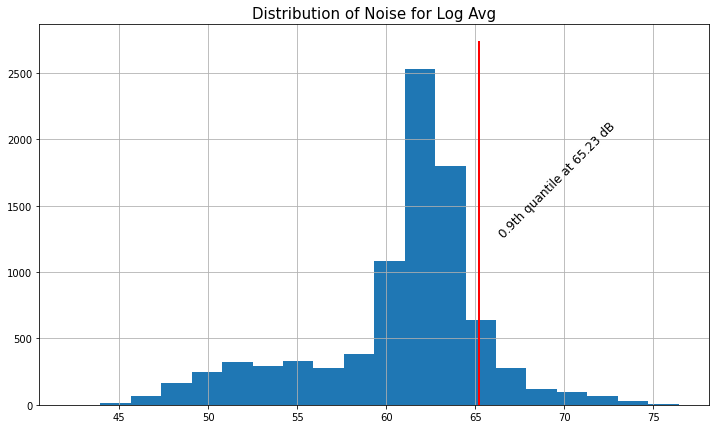

In [49]:
def plot_hist(df):    
    """
    returns histplot with labelling and title.
    """
    # plot distribution of noise
    plt.figure(figsize=(12,7))
    # histplot
    max_ = df.Log_Avg.value_counts(bins=20).max()
    df.Log_Avg.hist(bins=20)
    x=df.Log_Avg.quantile(.9)
    # line
    plt.plot([x,x], [0, max_+200], 'r', lw=2)
    # label
    plt.text(x=x+1, 
             y=max_/2, 
             s=f'0.9th quantile at {round(x,2)} dB', 
             size=12,
            rotation=45)
    plt.title('Distribution of Noise for Log Avg', size=15)
    plt.show()
    
# plot
plot_hist(df_final)

**Note**<br>
We decide to cut the df at the 0.9th quantile.

In [50]:
# split outliers
out = df_final.Log_Avg.quantile(.9)
df_final['is_outlier'] = df_final.Log_Avg.apply(lambda x: 1 if x > out else 0)
df_outliers = df_outliers[df_outliers.is_outlier == 1][['date_hour', 'is_outlier']]
df_outliers.head()

date_hour  is_outlier
0    2018-01-01 00:00:00           1
1    2018-01-01 01:00:00           1
143  2018-01-06 23:00:00           1
144  2018-01-07 00:00:00           1
145  2018-01-07 01:00:00           1

#### Correlations on Daily Averages

In [51]:
#### GET FILTERED COMPLAINTS #######
complaints_day_count = pd.read_csv('raw_data/complaints_filtered.csv',
                           index_col=0,
                        parse_dates=['Data']).groupby('Data')\
                                            .count()\
                                            .rename(columns={'Sottocategoria Criminologica':
                                                            'complaint_count'})
# put in data series
r = pd.date_range('2018-01-01', '2018-12-31', freq='d')
complaints_fin = complaints_day_count.reindex(r).rename_axis('final_date').fillna(0)

####### GET FOOTBALL MATCHES #############
matches = pd.read_csv('raw_data/matches_2018.csv', 
                    index_col=0,
                   parse_dates=['Date'])

# change date to normal day (without hours)
matches['day_date'] = matches.Date.apply(lambda x: x.floor('d'))
matches_daily = matches.groupby('day_date').max().drop(columns='Date') # catch the '1' or '0'

In [55]:
######## RESTRUCTURE DF #######
df_outliers['date_hour'] = pd.to_datetime(df_outliers.date_hour)
# change date to normal day (without hours)
df_outliers['day_date'] = df_outliers.date_hour.apply(lambda x: x.floor('d'))
df_outliers = df_outliers.groupby('day_date').sum()
df_outliers['is_weekend'] = df_outliers.index.map(lambda x: 1 if x.weekday() > 4 else 0)

# put in time series by day
r = pd.date_range('2018-01-01', '2018-12-31', freq='d')
outliers_fin = df_outliers.reindex(r).rename_axis('final_date').fillna(0)

outliers_fin.head(8)

is_outlier  is_weekend
final_date                        
2018-01-01         2.0         0.0
2018-01-02         0.0         0.0
2018-01-03         0.0         0.0
2018-01-04         0.0         0.0
2018-01-05         0.0         0.0
2018-01-06         1.0         1.0
2018-01-07         2.0         1.0
2018-01-08         6.0         0.0

In [56]:
# check correlations
corr_daily = outliers_fin.join(complaints_fin).join(matches_daily).corr()
corr_daily

is_outlier  is_weekend  complaint_count  is_match_pad  \
is_outlier          1.000000    0.472665        -0.165218      0.257440   
is_weekend          0.472665    1.000000        -0.568970      0.328528   
complaint_count    -0.165218   -0.568970         1.000000     -0.166040   
is_match_pad        0.257440    0.328528        -0.166040      1.000000   
is_home_juve_pad    0.150362    0.233561        -0.071103      0.556011   
is_home_fc_pad      0.078004    0.176007        -0.136564      0.344031   

                  is_home_juve_pad  is_home_fc_pad  
is_outlier                0.150362        0.078004  
is_weekend                0.233561        0.176007  
complaint_count          -0.071103       -0.136564  
is_match_pad              0.556011        0.344031  
is_home_juve_pad          1.000000       -0.093691  
is_home_fc_pad           -0.093691        1.000000

<AxesSubplot:>

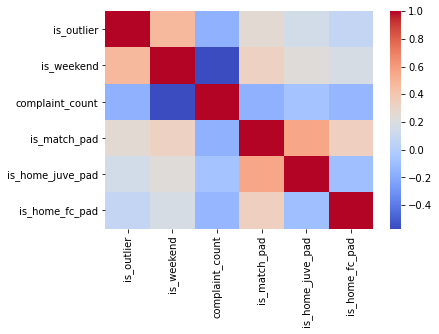

In [57]:
# plot correlations
sns.heatmap(corr_daily, cmap='coolwarm')

**Note**<br>
- Football matches correlate with high counts of outliers.
- Weekends signal high counts of noise outliers.
- The count of complaints doesn't seem to be contributory to the noise.

In [58]:
px.scatter(outliers_fin.join(complaints_fin).join(matches_daily),
          title='Outlier Count vs. Complaint Count')

**Note**<br>
- There is a seasonal 'bump' in September for noise and complaints (data set incomplete?)
- It is hard to see patterns between outliers and complaints. 

### General Correlations

#### Hourly Granularity

In [65]:
df_avg = df_final[['date_hour', 'Log_Avg', 'flow_mean']].set_index('date_hour')

In [66]:
####### GET OPENING HOURS ##########
opening = pd.read_csv('raw_data/business_open_2018.csv', 
                      index_col=0,
                     parse_dates=['hour']).set_index('hour').rename(columns={'count':
                                                                    'opening_count'})

####### GET FOOTBALL MATCHES #######
matches = pd.read_csv('raw_data/matches_2018.csv', 
                    index_col=0,
                   parse_dates=['Date']).set_index('Date')

In [67]:
# check correlation
corr_hourly = df_avg.join(matches).join(opening).corr()
corr_hourly

Log_Avg  flow_mean  is_match_pad  is_home_juve_pad  \
Log_Avg           1.000000   0.548538     -0.035154         -0.000301   
flow_mean         0.548538   1.000000     -0.077610         -0.045414   
is_match_pad     -0.035154  -0.077610      1.000000          0.563303   
is_home_juve_pad -0.000301  -0.045414      0.563303          1.000000   
is_home_fc_pad   -0.030313  -0.032989      0.357908         -0.034987   
opening_count     0.517871   0.649352     -0.100891         -0.047748   

                  is_home_fc_pad  opening_count  
Log_Avg                -0.030313       0.517871  
flow_mean              -0.032989       0.649352  
is_match_pad            0.357908      -0.100891  
is_home_juve_pad       -0.034987      -0.047748  
is_home_fc_pad          1.000000      -0.043926  
opening_count          -0.043926       1.000000

<AxesSubplot:>

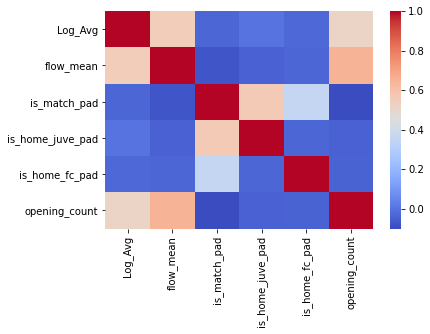

In [68]:
# plot heatmap
sns.heatmap(corr_hourly, cmap='coolwarm')

**Note**<br>
- The amount of Cafes, Bars and Restaurants being open correlates well with the recorded noise.
- When measuring matches on an hourly basis (15:00-09: of following day), there is little to no correlation between matches and noise. 
- Cars (```flow_mean```) have a considerable correlation with noise development.

#### Weekday Granularity

In [63]:
# Group Sensors by Weekday
df_avg['weekday'] = df_avg.index.map(lambda x: x.weekday())
df_avg_weekday = df_avg.groupby('weekday').mean()[['Log_Avg']]

# group opening hours
opening['weekday'] = opening.index.map(lambda x: x.weekday())
opening_weekday = opening.groupby('weekday').mean()

# group complaints
complaints_fin['weekday'] = complaints_fin.index.map(lambda x: x.weekday())
complaints_weekday = complaints_fin.groupby('weekday').mean()

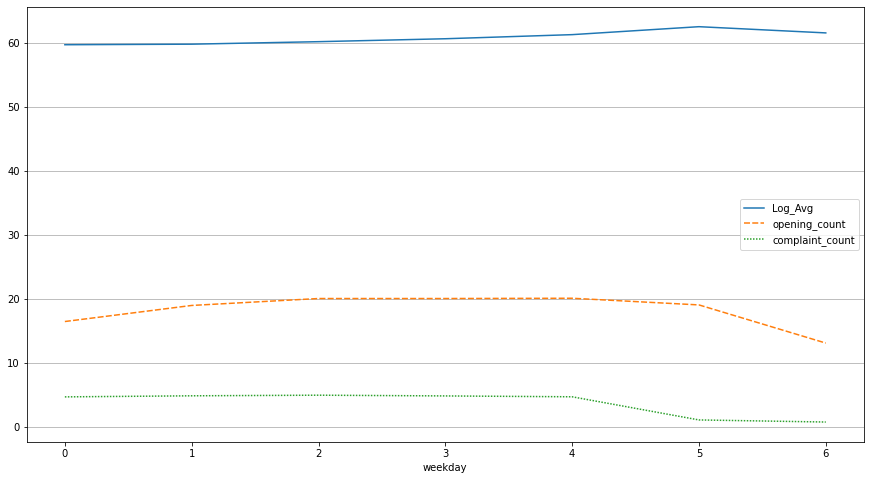

In [64]:
joint_weekday = df_avg_weekday.join(opening_weekday).join(complaints_weekday)

# plot
plt.figure(figsize=(15,8))
sns.lineplot(data=joint_weekday)
plt.grid(axis='y')

**Note**<br>
- There is an elbow visible starting at the weekend. 
- complaints generally decrease over the weekend. 
- The highest noise is emitted on Saturdays.

## Feature Selection

In [25]:
#Checking the propotion of null values in each feature
df_final.isnull().sum().sort_values(ascending=False)/len(df_final)

winds                 0.949543
numero_presenze       0.942580
dettaglio(secondi)    0.942580
No. of Visitors       0.812900
count_open            0.578539
count_close           0.513128
rainfall_mm           0.022374
snowfall_mm           0.022146
speed_mean            0.002854
flow_mean             0.002854
n                     0.002854
flow_sd               0.002854
flow_median           0.002854
speed_sd              0.002854
speed_median          0.002854
is_match_pad          0.002626
count_complaint       0.002626
is_home_pad           0.002626
date                  0.000000
Ora                   0.000000
date_hour             0.000000
temp                  0.000000
Log_Avg               0.000000
day                   0.000000
isHoliday             0.000000
dtype: float64

In [229]:
df_final.drop(columns=['winds','numero_presenze','dettaglio(secondi)','No. of Visitors'],inplace=True)

In [230]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean") # Instanciate a SimpleImputer object with strategy of choice

imputer.fit(df_final[['count_open','count_close','rainfall_mm','snowfall_mm','flow_median','flow_sd','flow_mean','n','speed_mean','speed_sd','speed_median','count_complaint','is_match_pad','is_home_pad']]) # Call the "fit" method on the object

df_final[['count_open','count_close','rainfall_mm','snowfall_mm','flow_median','flow_sd','flow_mean','n','speed_mean','speed_sd','speed_median','count_complaint','is_match_pad','is_home_pad']] = imputer.transform(df_final[['count_open','count_close','rainfall_mm','snowfall_mm','flow_median','flow_sd','flow_mean','n','speed_mean','speed_sd','speed_median','count_complaint','is_match_pad','is_home_pad']]) # Call the "transform" method on the object
imputer.statistics_ # The mean is stored in the transformer's memory

array([2.81408451e+01, 2.43756155e+01, 1.36995303e-02, 1.46451319e+01,
       4.93808517e+03, 3.35830969e+03, 5.56629703e+03, 9.69660332e+02,
       3.49491629e+02, 1.36403073e+02, 3.16182921e+02, 3.51379192e-02,
       1.04383656e-01, 5.21918279e-02])

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Ora              8760 non-null   int64  
 1   date_hour        8760 non-null   object 
 2   day              8760 non-null   int64  
 3   Log_Avg          8760 non-null   float64
 4   temp             8760 non-null   float64
 5   rainfall_mm      8760 non-null   float64
 6   snowfall_mm      8760 non-null   float64
 7   is_match_pad     8760 non-null   float64
 8   is_home_pad      8760 non-null   float64
 9   count_close      8760 non-null   float64
 10  count_open       8760 non-null   float64
 11  count_complaint  8760 non-null   float64
 12  n                8760 non-null   float64
 13  flow_mean        8760 non-null   float64
 14  flow_sd          8760 non-null   float64
 15  flow_median      8760 non-null   float64
 16  speed_mean       8760 non-null   float64
 17  speed_sd      

### Forward/backwards stepwise regression (for testing features that contribute best to the final output required)

In [231]:
df_feature_selection = df_final.copy()
X = df_feature_selection.drop(columns=['Log_Avg','date_hour','date'])
y = df_feature_selection['Log_Avg']

In [232]:
## feature importance
#RECURSIVE FEATURE ELIMINATION
#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
names=pd.DataFrame(X.columns)

#use linear regression as the model
lin_reg = LinearRegression()

#This is to select 5 variables: can be changed and checked in model for accuracy
rfe_mod = RFE(lin_reg, 5, step=1) #RFECV(lin_reg, step=1, cv=5) 
myvalues=rfe_mod.fit(X,y) #to fit
myvalues.support_#The mask of selected features.
myvalues.ranking_ #The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected (i.e., estimated best) features are assigned rank 1.

rankings=pd.DataFrame(myvalues.ranking_) #Make it into data frame
rankings

0
0    2
1    1
2    5
3    1
4    8
5    1
6    1
7    6
8    9
9    1
10  10
11  12
12  13
13  11
14   3
15   7
16   4
17  14

In [233]:
#Concat and name columns
ranked=pd.concat([names,rankings], axis=1)
ranked.columns = ["Feature", "Rank"]
ranked

#Select most important (Only 1's)
most_important = ranked.loc[ranked['Rank'] < 5] 
print(most_important)

most_important['Rank'].count()

            Feature  Rank
0               Ora     2
1               day     1
3       rainfall_mm     1
5      is_match_pad     1
6       is_home_pad     1
9   count_complaint     1
14       speed_mean     3
16     speed_median     4


8

The top ranked attributes that has greater impact on the noise are hour(time like 1:00,2:00 like that), Day(sunday or monday like that), rainfall_mm, is_match_pad (is the match going on at match pad), is_home_pad (is the match going on at home)

### Univariate Selection

In [234]:
#UNIVARIATE SELECTION
# Feature Extraction with Univariate Statistical Tests (f_regression)
import pandas
import numpy
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.datasets import load_digits

# load data
names=pd.DataFrame(X.columns)

model = SelectKBest(score_func=f_regression, k=4)
results = model.fit(X, y)

#print (results.scores_)
#print (results.pvalues_)

results_df=pd.DataFrame(results.scores_)
#Concat and name columns
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score'],ascending=False)[1:]
#The higher the score, the more important the variable. 

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning:

invalid value encountered in true_divide



Feature        Score
11        flow_mean  3740.820203
12          flow_sd  3529.063325
15         speed_sd  1314.487768
0               Ora  1314.085796
14       speed_mean  1233.628554
16     speed_median   803.721860
7       count_close   708.338203
1               day   150.151141
4       snowfall_mm   124.834451
9   count_complaint    94.320556
2              temp    93.651074
10                n    53.944131
8        count_open    22.473745
5      is_match_pad    13.988683
3       rainfall_mm    13.396048
6       is_home_pad     3.465901
17        isHoliday          NaN

From the univariate selection method we got some more features that effect the noise reading, they include flow_mean,flow_sd,speed_sd, Ora, speed_mean

In [235]:
#Let's Consider only the features having greater impact for modelling
df_model_data=df_final[['is_home_pad','flow_mean','flow_sd','speed_sd','Ora','speed_mean','Log_Avg','day','rainfall_mm','is_match_pad']]
df_model_data.head(4)

is_home_pad  flow_mean   flow_sd  ...  day  rainfall_mm  is_match_pad
0          0.0   2297.135  1304.423  ...    0       -0.010           0.0
1          0.0   4479.686  2634.671  ...    0        0.009           0.0
2          0.0   3796.326  2292.005  ...    0        0.008           0.0
3          0.0   2777.488  1622.614  ...    0        0.006           0.0

[4 rows x 10 columns]

## Correlation Analysis

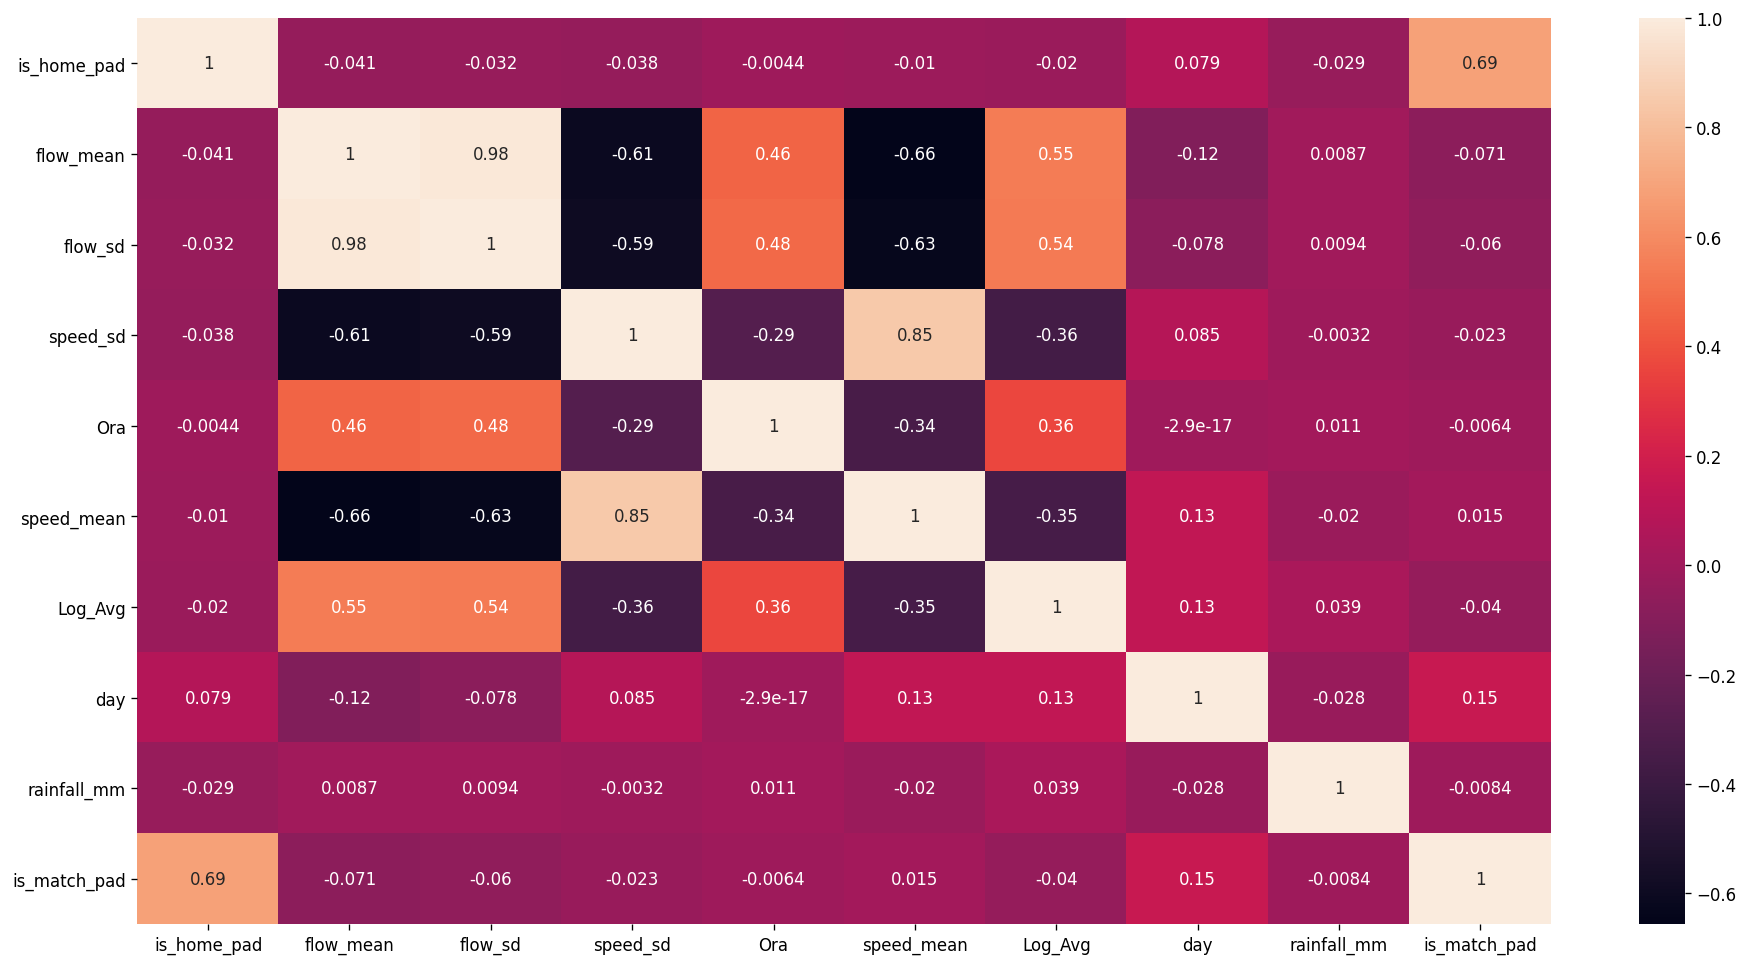

In [237]:
correlation_mat = df_model_data.corr()
f = plt.figure(figsize=(19, 10))
sns.heatmap(correlation_mat, annot = True)
plt.show()

In [238]:
correlation_mat['Log_Avg'].sort_values(ascending=False)

Log_Avg         1.000000
flow_mean       0.547078
flow_sd         0.535927
Ora             0.361204
day             0.129829
rainfall_mm     0.039080
is_home_pad    -0.019889
is_match_pad   -0.039934
speed_mean     -0.351378
speed_sd       -0.361252
Name: Log_Avg, dtype: float64

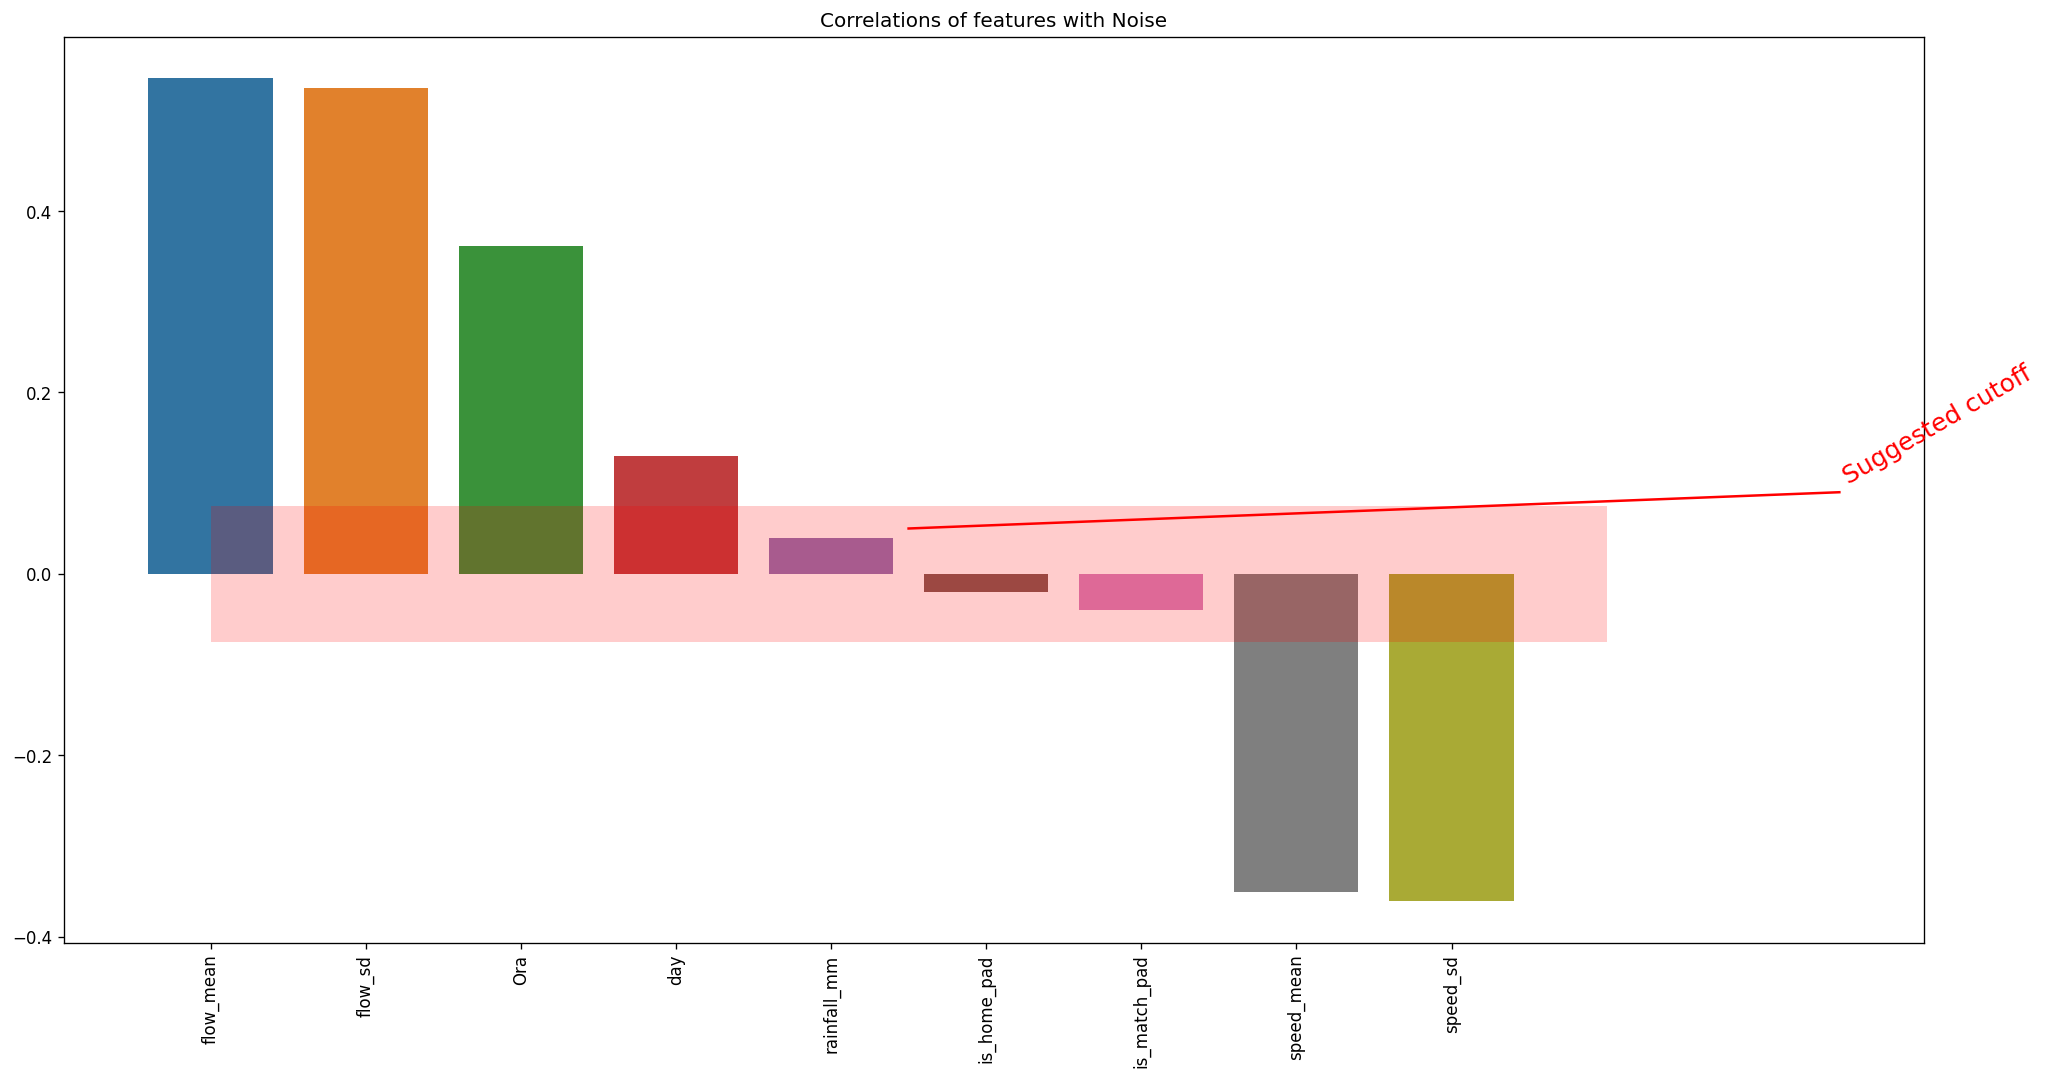

In [239]:
df = df_model_data.copy()

feats = df[[x for x in df.columns if 'feat_' in x]]
corr = df.drop(columns=['Log_Avg']).corrwith(df['Log_Avg'], 
                                              axis=0).sort_values(ascending=False)
plt.figure(figsize=(20,10))
# plot
ax = sns.barplot(x=corr.keys(), y=corr)
plt.xticks(rotation=90)

# rectangle
rect = patches.Rectangle((0, -.075), len(corr), .15, 
                         linewidth=0,  
                         facecolor='r',
                         alpha=.2)
ax.add_patch(rect)
# text
plt.title('Correlations of features with Noise')
plt.text(x=len(corr)/2+6, 
         y=.10, 
         s='Suggested cutoff',
         rotation=30,
         color='r',
         size=15)

# line
plt.plot((len(corr)/2, len(corr)/2+6), 
         (.05, .09),
        c='r')
plt.show()

In [240]:
# perform cutoff within  90 %
column_select = list(corr[~corr.between(-.2, .2)].keys())
column_select.append('Log_Avg')

In [241]:
#List of columns showing better correlation with the noise reading Log_Avg
column_select

['flow_mean', 'flow_sd', 'Ora', 'speed_mean', 'speed_sd', 'Log_Avg']

# Modelling

We considered several models for predicting the noise like regression models, deep learning models,ARIMA etc

We have added the code realted to all the models we used in the **Appendix**

After testing all the models we considered only few that have the greater impact, they include:

1. Baseline Model(Linear Regression)
2. Moving Average
3. ARIMA
4. LSTM

##Final Dataframe Accessing 

Here we are considering the list of columns that we got after applying the univariate selection, forward and backward regression technique and the correlation analysis

In [242]:
data_model=df_model_data[column_select]
data_model.head()

flow_mean   flow_sd  Ora  speed_mean  speed_sd    Log_Avg
0   2297.135  1304.423    0     369.392   135.967  70.253908
1   4479.686  2634.671    1     341.489   122.820  65.424707
2   3796.326  2292.005    2     328.034   114.294  61.332068
3   2777.488  1622.614    3     322.364   109.699  64.069742
4   1987.818  1166.373    4     342.330   124.187  63.175181

##Modelling

### Getting Log_Avg values of previous times

In [243]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy

In [244]:
list_of_attributes = ['Log_Avg']

list_of_prev_t_instants = []
for i in range(24,361,24): #we can change this list as list of times with most impact
    list_of_prev_t_instants.append(i)

list_of_prev_t_instants

[24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336, 360]

In [245]:
df_new = create_regressor_attributes(data_model, list_of_attributes, list_of_prev_t_instants)
df_new.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



flow_mean  flow_sd  ...  Log_Avg_(t-336)  Log_Avg_(t-360)
datetime                      ...                                  
360        1330.980  821.096  ...        57.592027        70.253908
361         689.196  451.331  ...        56.422202        65.424707
362         410.238  278.849  ...        52.124511        61.332068
363         348.208  227.213  ...        49.439248        64.069742
364         525.785  378.296  ...        49.730202        63.175181

[5 rows x 21 columns]

In [246]:
df_new.corr()['Log_Avg'].sort_values()

speed_sd          -0.362075
speed_mean        -0.351085
Ora                0.361636
Log_Avg_(t-264)    0.473139
Log_Avg_(t-240)    0.474699
Log_Avg_(t-96)     0.476554
Log_Avg_(t-72)     0.476599
Log_Avg_(t-288)    0.502861
Log_Avg_(t-216)    0.504885
Log_Avg_(t-120)    0.509799
Log_Avg_(t-48)     0.510166
flow_sd            0.535892
flow_mean          0.547631
Log_Avg_(t-360)    0.689030
Log_Avg_(t-312)    0.695194
Log_Avg_(t-192)    0.703043
Log_Avg_(t-144)    0.710440
Log_Avg_(t-24)     0.715335
Log_Avg_(t-336)    0.884857
Log_Avg_(t-168)    0.892671
Log_Avg            1.000000
Name: Log_Avg, dtype: float64

####Spliting the dataset into train, validation and test sets

In [247]:
test_set_size = 0.05
valid_set_size= 0.05

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (7581, 20) (7581,)
Shape of validation inputs, validation target: (399, 20) (399,)
Shape of test inputs, test target: (420, 20) (420,)


### Linear Regression

In [248]:
X = df_new.drop(columns=['Log_Avg'])
y = df_new['Log_Avg']

In [249]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [250]:
Lin_reg = LinearRegression()
Lin_reg.fit(X_train, y_train)
y_pred = Lin_reg.predict(X_test)
score = r2_score(y_test, y_pred)
print('R-squared score for the test set: ', round(score,4))

R-squared score for the test set:  0.8556


### Moving Average

Moving Average Smoothing is a technique applied to time series to remove the fine-grained variation between time steps. The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes.

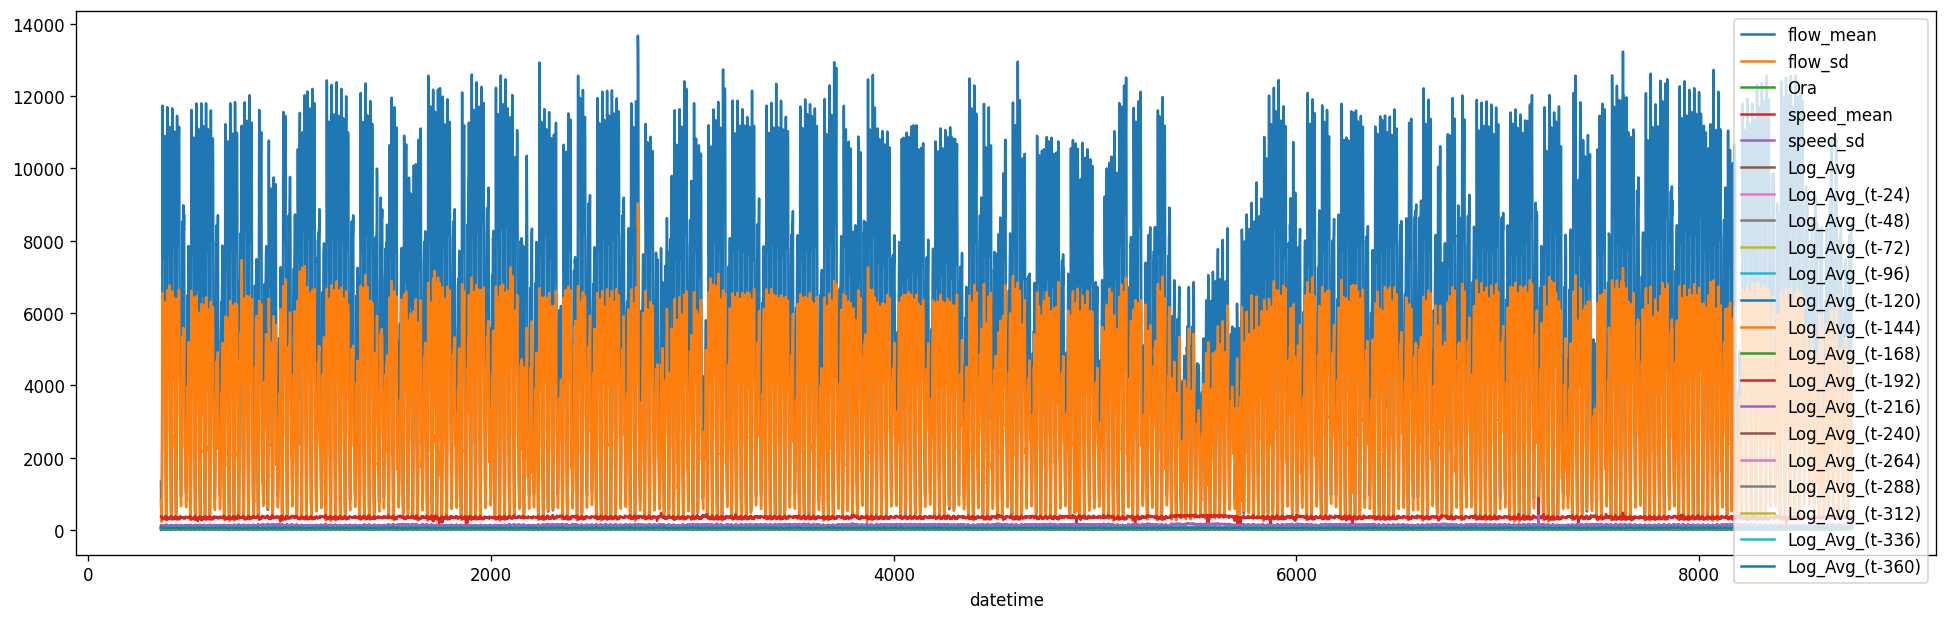

In [251]:
plt.rcParams["figure.figsize"] = (20,6)
df_new.plot()

     flow_mean      flow_sd  Ora  speed_mean    speed_sd    Log_Avg  datetime
2  3524.382333  2077.033000  1.0  346.305000  124.360333  65.670228       1.0
3  3684.500000  2183.096667  2.0  330.629000  115.604333  63.608839       2.0
4  2853.877333  1693.664000  3.0  330.909333  116.060000  62.858997       3.0
5  2041.229667  1189.952333  4.0  336.971333  120.632667  60.999306       4.0
6  1525.357333   916.519667  5.0  348.819000  130.338667  58.275637       5.0


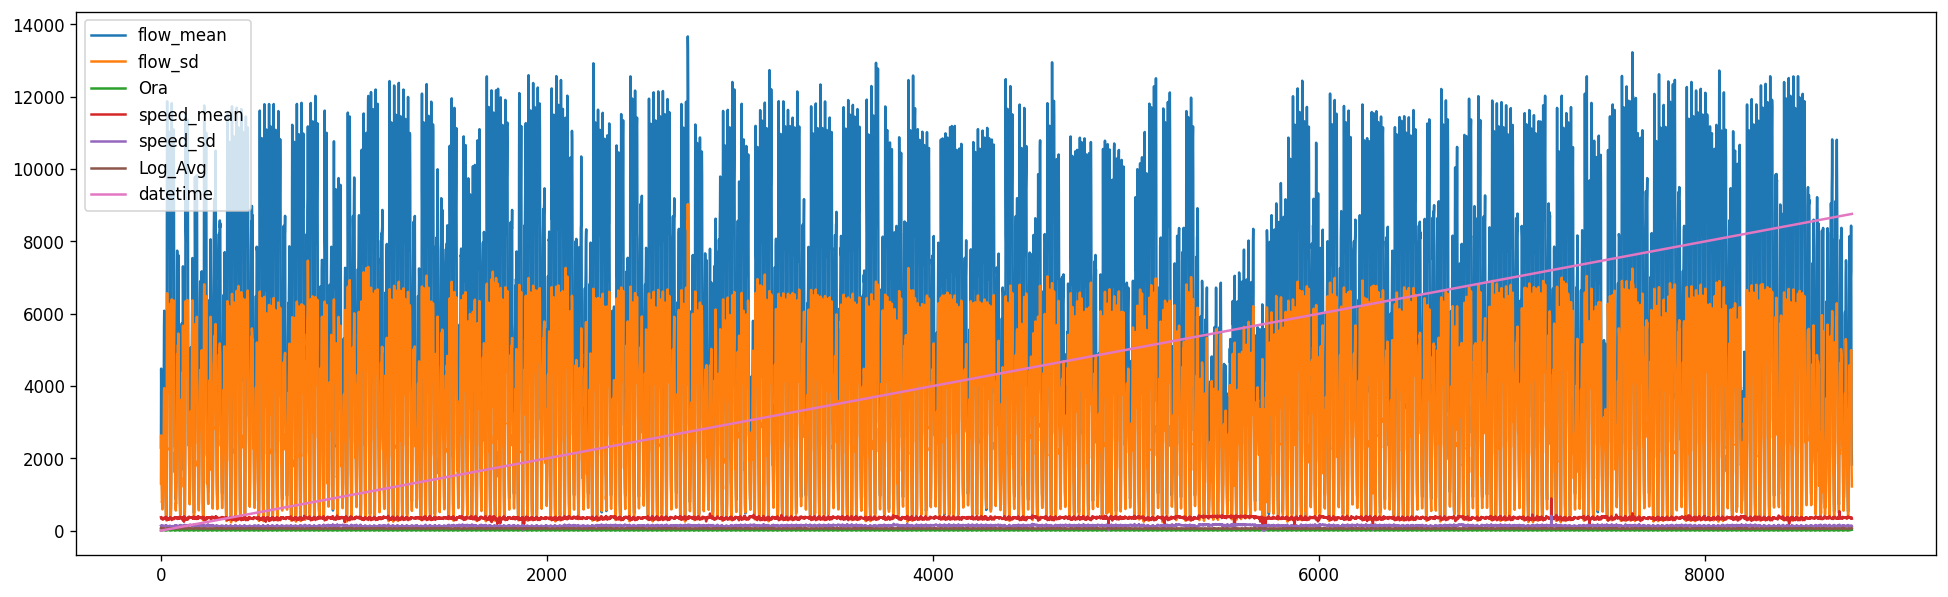

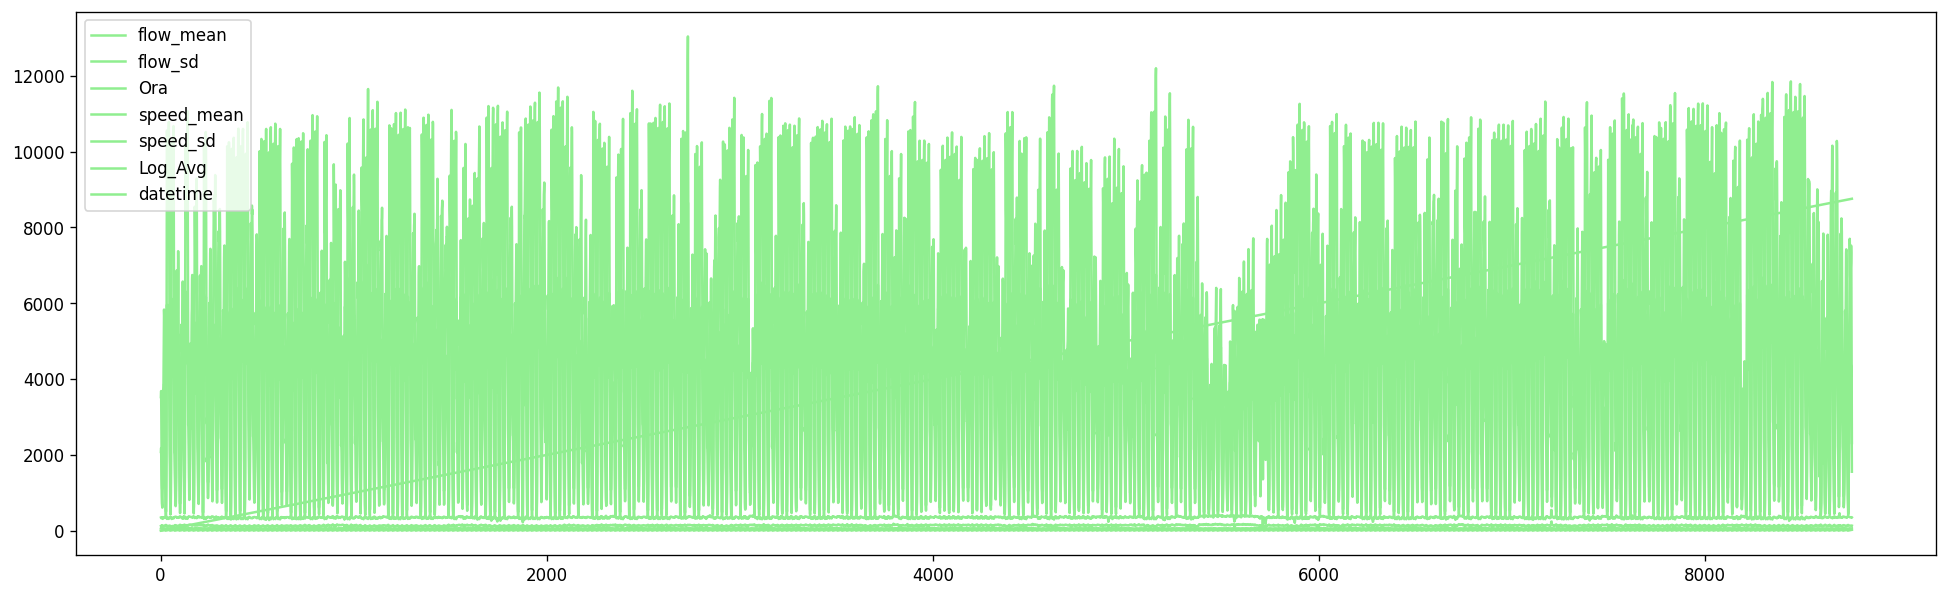

In [252]:
# Tail-rolling average transform
rolling = data_model.rolling(window=3)
rolling_mean = rolling.mean()
rolling_mean.dropna(inplace= True)
print(rolling_mean.head())
# plot original and transformed dataset
data_model.plot()
rolling_mean.plot(color='lightgreen')

Test MSE: 17.794


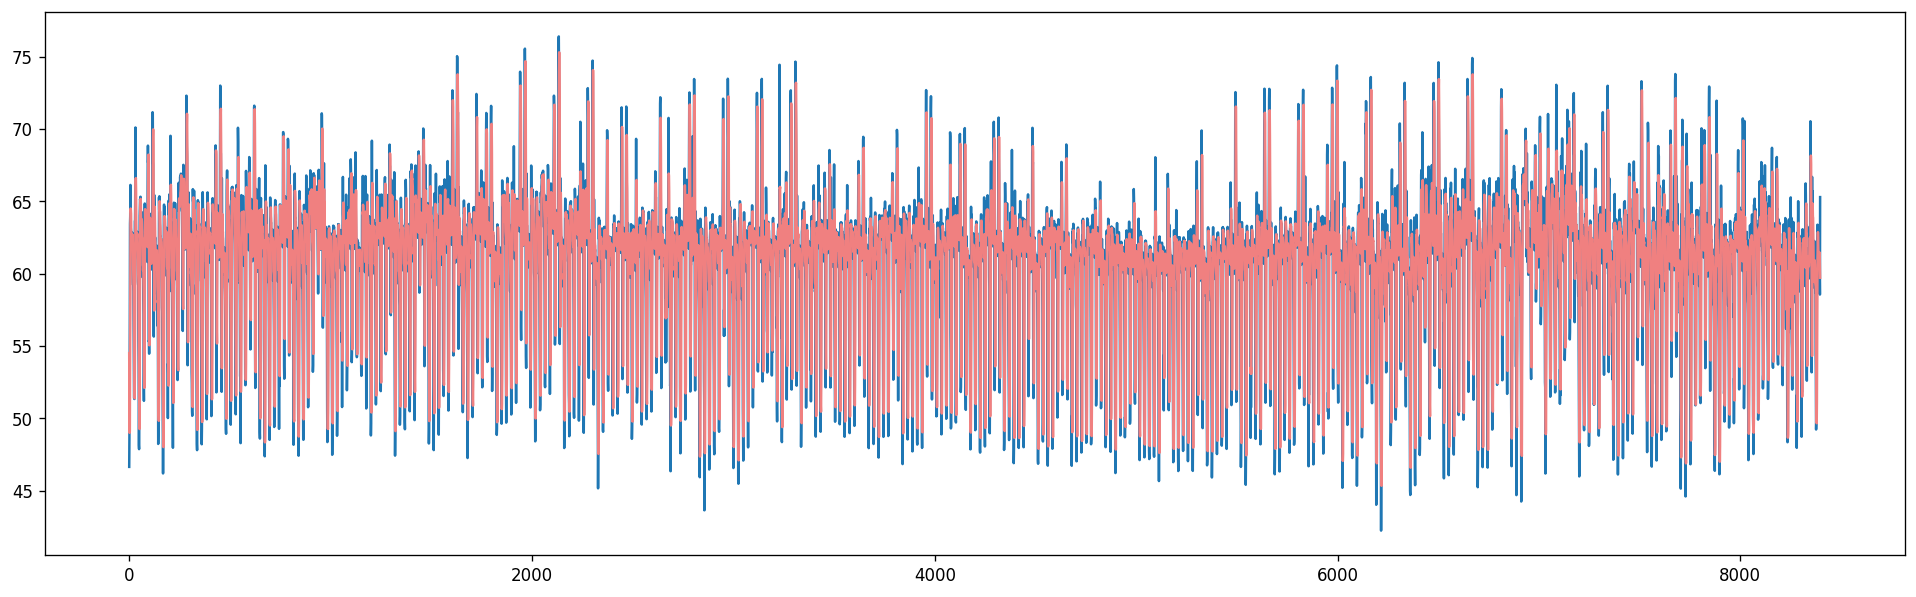

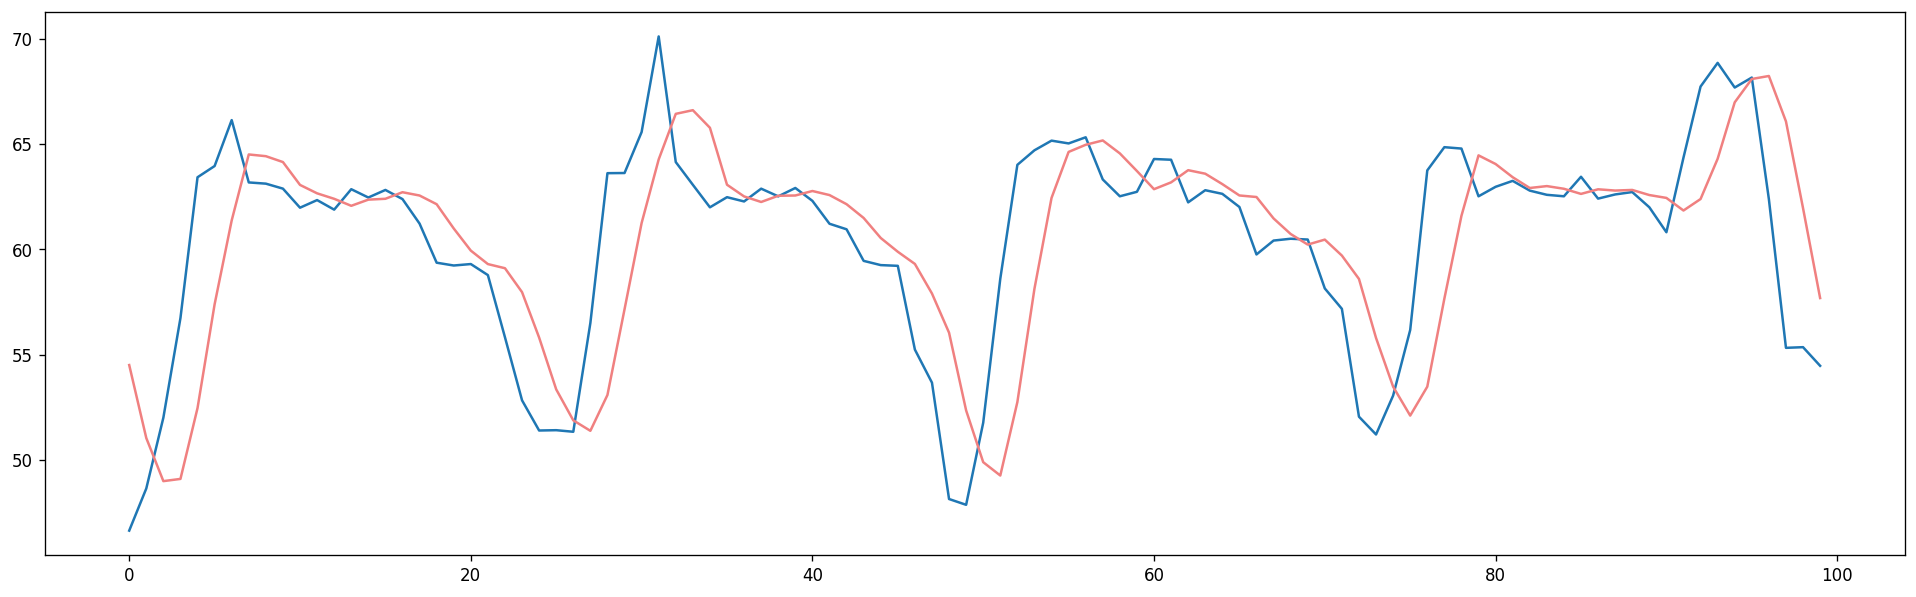

In [253]:
from pandas import read_csv
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
# prepare situation
X = df_new['Log_Avg'].values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
	length = len(history)
	yhat = mean([history[i] for i in range(length-window,length)])
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='lightcoral')
pyplot.show()
# zoom plot
pyplot.plot(test[0:100])
pyplot.plot(predictions[0:100], color='lightcoral')
pyplot.show()

# Appendix

## Weather Data

### Data

In [ ]:
weather = pd.read_csv('raw_data/weather/weather_1.csv',
#                       nrows=1000, #rm later
                      sep=';',
#                       decimal=',',
                      skiprows=4,
#                       parse_dates=[[0, 1]],
#                       dayfirst=True,
                      header=0,
                      names=['date', 'hour', 'rainfall_mm', 'snowfall_mm'],
                     )

# workaround for hour concat issue
weather['date'] = pd.to_datetime(weather['date'], format='%d-%m-%Y', errors='coerce')
weather['date_hour'] = weather.apply(lambda x: pd.to_datetime(str(x.date) + ' ' + str(x.hour), errors='coerce'), axis=1)

# workaround for decimal issue
weather['rainfall_mm'] = weather.rainfall_mm.apply(lambda x: str(x).replace(',','.'))
weather['snowfall_mm'] = weather.snowfall_mm.apply(lambda x: str(x).replace(',','.'))

In [ ]:
weather2 = pd.read_csv('raw_data/weather/weather_2.csv', 
                 sep=';', 
                 skiprows=4, 
                 header=0, 
#                  decimal=',',
#                 converters={2:lambda x: x.replace(',', '.')},
#                 parse_dates=[[0, 1]],
                names=['date', 'hour', 'winds'],
                na_values={2:'',
                            3:''},
                dayfirst=True,
                )
# workaround for hour concat issue
weather2['date'] = pd.to_datetime(weather2['date'], format='%d-%m-%Y', errors='coerce')
weather2['date_hour'] = weather2.apply(lambda x: pd.to_datetime(str(x.date) + ' ' + str(x.hour), errors='coerce'), axis=1)

weather2['winds'] = weather2.winds.apply(lambda x: str(x).replace(',','.'))

In [ ]:
# weather['date_hour'] = pd.to_datetime(weather['date_hour'], errors='coerce')
weather_1 = weather.dropna(subset=['date_hour'])

# weather2['date_hour'] = pd.to_datetime(weather2['date_hour'], errors='coerce')
weather_2 = weather2.dropna(subset=['date_hour'])

In [ ]:
merged_weather = weather_2.merge(weather_1,
                                right_on='date_hour',
                                left_on='date_hour',
                                )

In [ ]:
merged_weather.sort_values(by='date_hour').tail()
merged_weather['hourly_date'] = merged_weather.date_hour.apply(lambda x: x.floor('h'))

In [ ]:
merged_weather = merged_weather.astype({'winds': float,
                      'rainfall_mm':float,
                      'snowfall_mm':float})

In [ ]:
hourly_weather = merged_weather.groupby('hourly_date').mean()

In [ ]:
hourly_weather.info()

In [ ]:
hourly_weather.to_csv('hourly_weather.csv')

In [ ]:
hourly_weather.head()

### Open Weather Map

In [ ]:
# API KEY
load_dotenv(find_dotenv())
OWM_API = os.environ.get("OWM_API")

In [ ]:
# init time range
range_2019 = pd.DataFrame(pd.date_range('2016-06-01', '2021-06-12', freq='h'), columns=['hour'])
range_2019.tail().hour

In [ ]:
req = 'http://history.openweathermap.org/data/2.5/history/wdl'
start = range_2019.hour.min().value
inter = range_2019.hour.max().value
end = range_2019.hour.max().value
# tail1 = tail.min().value
# tail2 = tail.max().value
params = {
    'id':'3165524', # ID of Turin
    'type':'hour',
    'start':str(start)[:10], # unix time
    'end':str(end)[:10],
    'appid': OWM_API
}

r = requests.get(req, params=params)


# with open('data/weather.txt', 'w') as outfile:
#     json.dump(r.json(), outfile)
    
weather = r.json()
lst = weather.get('list')
dct = {x.get('dt'):x.get('weather')[0].get('main') for x in lst}
weather_df = pd.DataFrame.from_dict(dct, 
                                    orient='index', 
                                    columns=['weather']).reset_index().rename(columns={'index':'time'})
weather_df['rain'] = weather_df.weather == 'Rain'

In [ ]:
lst = weather.get('list')
dct = {x.get('dt'):x.get('main').get('temp') for x in lst}

In [ ]:
weather_df = pd.DataFrame.from_dict(dct, 
                                    orient='index', 
                                    columns=['temp']).reset_index().rename(columns={'index':'time'})
weather_df['temp'] = weather_df.temp-273.15
weather_df['time'] = pd.to_datetime(weather_df.time, unit='s')

In [ ]:
merge_all = weather_df.merge(hourly_weather, left_on='time', right_index=True)

In [ ]:
merge_all.to_csv('all_weather.csv')

## Matches Data

In [ ]:
# API KEY
load_dotenv(find_dotenv())
FOOTBALL = os.environ.get("FOOTBALL")

In [ ]:
# headers = {'X-Auth-Token': FOOTBALL}
# url = 'https://api.football-data.org/v2/matches'
# params = {'dateFrom': '2018-04-14',
#          'dateTo': '2018-04-16'}
# r = requests.get(url, headers=headers, params=params)
# r.json()

In [ ]:
root = 'raw_data/football/'
dfs = []
for i in os.listdir(root):
    if '.csv' in i:
        df = pd.read_csv(root+i)
        dfs.append(df)

In [ ]:
# filter all by juve
juve1 = dfs[0][(dfs[0]['HomeTeam'] == 'Juventus') \
              | (dfs[0]['AwayTeam'] == 'Juventus')]['Date']
juve1 = pd.to_datetime(juve1, format='%d/%m/%Y')

juve2 = dfs[1][(dfs[1]['Home Team'] == 'Juventus') \
               | (dfs[1]['Away Team'] == 'Juventus')]['Date']
juve2 = pd.to_datetime(juve2.apply(lambda x: x[:10]), format="%d/%m/%Y")

juve3 = dfs[2][(dfs[2]['HomeTeam'] == 'Juventus') \
              | (dfs[2]['AwayTeam'] == 'Juventus')]['Date']
juve3 = pd.to_datetime(juve3, format='%d/%m/%y')

juve4 = dfs[3][(dfs[3]['Home Team'] == 'Juventus') \
               | (dfs[3]['Away Team'] == 'Juventus')]['Date']
juve4 = pd.to_datetime(juve4.apply(lambda x: x[:10]), format="%d/%m/%Y")

In [ ]:
# concat all dates
all_concat = pd.DataFrame(pd.concat([juve1, juve2, juve3, juve4]))
# all_concat['Date'] = pd.to_datetime(all_concat.Date)
all_concat['is_match'] = 1

In [ ]:
all_concat.sort_values(by='Date')

In [ ]:
# get all 2018 matches
all_concat_2018 = all_concat[(all_concat.Date > '01-01-2018') \
                            & (all_concat.Date < '2018-12-31')]

In [ ]:
# put in 2018 time series
r = pd.date_range('2018-01-01', '2018-12-31', freq='h')
matches = all_concat_2018.set_index('Date').reindex(r).rename_axis('Date').reset_index()

In [ ]:
matches.head()

In [ ]:
matches.to_csv('raw_data/football/matches_2018.csv')

## Opening Hours Data

This part is a bit messy, so we will explain: 
We used the ```nearbysearch``` [Link](https://developers.google.com/maps/documentation/places/web-service/search#PlaceSearchRequests) to get all the ```bars``` and ```restaurants``` business hours. 

Then we fetch the unique id ```reference``` from the list of businesses and run it through the ```place_details``` API [Link](https://developers.google.com/maps/documentation/places/web-service/details)

From there we extract all the ```open``` (time-)elements and ```close``` (time-)elements and stack them in a dataframe divided by days of the week (0-6). 

In the end we merge the findings with an empty time series of 2018 with an 'hourly' sequence. 


In [ ]:
# API KEY
load_dotenv(find_dotenv())
GOOGLE = os.environ.get("GOOGLE")

In [ ]:
# first find all bars

url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json'
params = {            
            'location':'45.05917,7.67899', #sensor
            'radius':'200',
            'type':'restaurant',
            'key':GOOGLE,
            'next_page_token':'Aap_uED24ODLIlOhPdAHG7xFrCg_OrsQ_jAruvTm3QSG4Qbnp5Q85Aa4K7ar-QgnGI7Xnl1epc9YIEj17piMfVpFUxQysBwi8XTzdWbtl6IBGKTKQwV_kxhaAUWr8JG6XVo-BVKHd8NJUwiTP-_uQvkKxc5vLZ4-v6T8ZBuS42zw5DE1L2KgNPCbm86EsPhPYOj8L1MXTRdEm_GhmQSdOt8nDxG4gKkbxiXvmHNTmuBLavqN-VrbpkRBBoVZz_t2P53_ShPgndMEwlt55EYlZHCYK2gHymy9WJjMjKn3VzS6CfcTQJ-TjgsxsrRjSqNXV4T5i2qusSJ__gsam11RBY8XRADB31i-ec_wYCh1529gNKKy9tdQbidVaQjAI72wQ-7yzTZXGzxpz8ob_DHkdVdyJLxijWoHqsXY7oQM-W3Db0u08SHwaooMyb3Da9Ij'
         } 

r = requests.get(url, params=params)
r.json()

In [ ]:
results = r.json().get('results')
results2 = r.json().get('results')
results3 = r.json().get('results')
results4 = r.json().get('results')
results5 = r.json().get('results')
results6 = r.json().get('results')

In [ ]:
bars = results + results2 + results3 + results4 + results5 + results6
restaurants = results + results2 + results3 + results4 + results5 + results6
len(restaurants)

In [ ]:
# get specific opening hrs from fetched bars/restaurants
url = 'https://maps.googleapis.com/maps/api/place/details/json'
params = {
    'key':GOOGLE,
    'fields':'opening_hours'
         }
opening_hrs = []
for bar in restaurants:
    reference = bar.get('reference')
    params['place_id'] = reference
    r = requests.get(url, params=params)
    opening_hrs.append(r)

In [ ]:
contents_hrs = [r.json() for r in opening_hrs]
periods = []
for x in contents_hrs:
    try:
        hr = x.get('result').get('opening_hours').get('periods')
        periods.append(hr)
    except:
        pass

In [ ]:
# remove 24h open bars
new = [x for x in periods if len(x) > 1]

In [ ]:
closing = []
for x in new:
    for i in x:
        _close = i.get('close')
        closing.append(_close)
opening = []
for x in new:
    for i in x:
        _open = i.get('open')
        opening.append(_open)

In [ ]:
opening_times_rest = pd.DataFrame(opening)
closing_times_rest = pd.DataFrame(closing)
closing_times_rest['time'] = pd.to_datetime(closing_times_rest['time'], format='%H%M')
opening_times_rest['time'] = pd.to_datetime(opening_times_rest['time'], format='%H%M')
closing_times_rest['day'] = closing_times_rest.day.apply(lambda x: x-1 if x != 0 else 6)
opening_times_rest['day'] = opening_times_rest.day.apply(lambda x: x-1 if x != 0 else 6)

In [ ]:
# create unique day_hr identifier
closing_times_rest['day_time'] = closing_times_rest.apply(lambda x: str(x.day) + '_' + str(x.time.hour), axis=1)
opening_times_rest['day_time'] = opening_times_rest.apply(lambda x: str(x.day) + '_' + str(x.time.hour), axis=1)

In [ ]:
# put results in dataframe
opening_times = pd.DataFrame(opening)
closing_times = pd.DataFrame(closing)
closing_times['time'] = pd.to_datetime(closing_times['time'], format='%H%M')
opening_times['time'] = pd.to_datetime(opening_times['time'], format='%H%M')
closing_times['day'] = closing_times.day.apply(lambda x: x-1 if x != 0 else 6)
opening_times['day'] = opening_times.day.apply(lambda x: x-1 if x != 0 else 6)

In [ ]:
# create unique day_hr identifier
closing_times['day_time'] = closing_times.apply(lambda x: str(x.day) + '_' + str(x.time.hour), axis=1)
opening_times['day_time'] = opening_times.apply(lambda x: str(x.day) + '_' + str(x.time.hour), axis=1)

In [ ]:
closing_all = pd.concat([closing_times_rest, closing_times])
opening_all = pd.concat([opening_times_rest, opening_times])

In [ ]:
# count all apperances of openings and closings per weekday
agg_close = closing_all.groupby('day_time').agg({'day':'count'}).rename(columns={'day':'count_close'})
agg_open = opening_all.groupby('day_time').agg({'day':'count'}).rename(columns={'day':'count_open'})
agg_joint = agg_close.join(agg_open, how='outer')

In [ ]:
# init range 2018
range_2018 = pd.DataFrame(pd.date_range('2018-01-01', '2018-12-31', freq='h'), columns=['hour'])
range_2018['day_time'] =  range_2018.apply(lambda x: str(x.hour.weekday()) + '_' + str(x.hour.hour), axis=1)

In [ ]:
# join both

opening_count_2018 = range_2018.merge(agg_joint, 
                                    on='day_time',
                                    how='left').drop(columns='day_time')

In [ ]:
opening_times

In [ ]:
opening_count_2018.sort_values(by='count_open')

In [ ]:
opening_count_2018.to_csv('raw_data/opening_count_2018.csv')

## Merging Dataframes

In [ ]:
df_noise_2018['date_hour'] = df_noise_2018['date_hour'].dt.strftime("%d-%m-%y %H:%M")
df_noise_2018.head()

Data  Ora    C1    C2    C3    C4    C5       date_hour  day    Log_Avg
0 2018-01-01    0  68.7  56.6  76.0  58.8  66.6  01-01-18 00:00    0  70.253908
1 2018-01-01    1  68.3  53.6  68.2  55.7  65.4  01-01-18 01:00    0  65.424707
2 2018-01-01    2  59.8  51.2  64.4  53.0  64.4  01-01-18 02:00    0  61.332068
3 2018-01-01    3  67.4  47.5  67.5  48.7  61.8  01-01-18 03:00    0  64.069742
4 2018-01-01    4  68.0  47.6  64.5  49.0  60.5  01-01-18 04:00    0  63.175181

In [ ]:
df_wifi.rename(columns = {'Time': 'date_time'}, inplace=True)
df_wifi.columns

Index(['date_time', 'No. of Visitors'], dtype='object')

In [ ]:
df_wifi['date_time'] = pd.to_datetime(df_wifi['date_time'])
df_wifi['date_time'] = df_wifi['date_time'].dt.strftime("%d-%m-%y %H:%M")

In [ ]:
df_weather['time'] = pd.to_datetime(df_weather['time'])
df_weather['time'] = df_weather['time'].dt.strftime("%d-%m-%y %H:%M")

In [ ]:
for x, line in enumerate(df_sim_all['data_a']):
    df_sim_all['data_a'][x] = line[8:10] + line[4:7] + '-' + line[0:4] +' ' + line[11:16]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_sim_all.rename(columns= {'data_a' : 'date_time'}, inplace=True)
df_sim_all.columns

Index(['date_time', 'index', 'numero_presenze', 'dettaglio(secondi)'], dtype='object')

In [ ]:
df_sim_all['date_time'] = pd.to_datetime(df_sim_all['date_time'])
df_sim_all['date_time'] = df_sim_all['date_time'].dt.strftime("%d-%m-%y %H:%M")
df_sim_all.head(2)

date_time  index  numero_presenze  dettaglio(secondi)
0  15-01-18 00:00  28710            17827               64800
1  15-01-18 01:00  28692            17640               64800

In [ ]:
df_opening_hours.rename(columns= {'hour' : 'date_time'}, inplace=True)
df_opening_hours['date_time'] = pd.to_datetime(df_opening_hours['date_time'])
df_opening_hours['date_time'] = df_opening_hours['date_time'].dt.strftime("%d-%m-%y %H:%M")
df_opening_hours.head(2)

date_time  count_close  count_open
0  01-01-18 00:00         66.0         NaN
1  01-01-18 01:00          6.0         NaN

In [ ]:
df_matches.rename(columns= {'Date' : 'date_time'}, inplace=True)
df_matches['date_time'] = pd.to_datetime(df_matches['date_time'])
df_matches['date_time'] = df_matches['date_time'].dt.strftime("%d-%m-%y %H:%M")
df_matches.head(2)

date_time  is_match_pad  is_home_pad
0  01-01-18 00:00           0.0          0.0
1  01-01-18 01:00           0.0          0.0

In [ ]:
df_complaints['final_date'] = pd.to_datetime(df_complaints['final_date'])
df_complaints['final_date'] = df_complaints['final_date'].dt.strftime("%d-%m-%y %H:%M")

In [ ]:
df_holidays['date_hour']= pd.to_datetime(df_holidays['date_hour'])
df_holidays['date_hour'] = df_holidays['date_hour'].dt.strftime("%d-%m-%y %H:%M")
df_holidays.head()

date_hour  isHoliday         Holiday
0  01-01-18 00:00          1  New year's Day
1  01-01-18 01:00          1  New year's Day
2  01-01-18 02:00          1  New year's Day
3  01-01-18 03:00          1  New year's Day
4  01-01-18 04:00          1  New year's Day

Merging noise, wifi, sim,weather,... police complaints

In [ ]:
df_final = df_noise_2018.merge(df_wifi, left_on= 'date_hour', right_on= 'date_time', how='left')
df_final.head(2)

Data  Ora    C1    C2  ...  day    Log_Avg  date_time No. of Visitors
0 2018-01-01    0  68.7  56.6  ...    0  70.253908        NaN             NaN
1 2018-01-01    1  68.3  53.6  ...    0  65.424707        NaN             NaN

[2 rows x 12 columns]

In [ ]:
df_final_1 = df_final.merge(df_sim_all, left_on= 'date_hour', right_on= 'date_time', how='left')
df_final_1.head(2)

Data  Ora    C1  ...  index  numero_presenze  dettaglio(secondi)
0 2018-01-01    0  68.7  ...    NaN              NaN                 NaN
1 2018-01-01    1  68.3  ...    NaN              NaN                 NaN

[2 rows x 16 columns]

In [ ]:
df_final_2 = df_final_1.merge(df_weather, left_on= 'date_hour', right_on= 'time', how='left')
df_final_2.head(2)

Data  Ora    C1    C2  ...  temp     winds  rainfall_mm snowfall_mm
0 2018-01-01    0  68.7  56.6  ...  1.04  0.366667       -0.010         2.6
1 2018-01-01    1  68.3  53.6  ...  1.09  0.590000        0.009         2.6

[2 rows x 21 columns]

In [ ]:
df_final_3 = df_final_2.merge(df_matches, left_on= 'date_hour', right_on= 'date_time', how='left')
df_final_3.head(2)

Data  Ora    C1  ...       date_time  is_match_pad  is_home_pad
0 2018-01-01    0  68.7  ...  01-01-18 00:00           0.0          0.0
1 2018-01-01    1  68.3  ...  01-01-18 01:00           0.0          0.0

[2 rows x 24 columns]

In [ ]:
df_final_4 = df_final_3.merge(df_opening_hours, left_on= 'date_hour', right_on= 'date_time', how='left')

In [ ]:
df_final_4.columns

Index(['Data', 'Ora', 'C1', 'C2', 'C3', 'C4', 'C5', 'date_hour', 'day',
       'Log_Avg', 'date_time_x', 'No. of Visitors', 'date_time_y', 'index',
       'numero_presenze', 'dettaglio(secondi)', 'time', 'temp', 'winds',
       'rainfall_mm', 'snowfall_mm', 'date_time_x', 'is_match_pad',
       'is_home_pad', 'date_time_y', 'count_close', 'count_open'],
      dtype='object')

In [ ]:
df_final_5=df_final_4.merge(df_complaints, left_on='date_hour', right_on = 'final_date', how ="left")
df_final_5.head(2)

Data  Ora    C1  ...  count_open      final_date  count_complaint
0 2018-01-01    0  68.7  ...         NaN  01-01-18 00:00              0.0
1 2018-01-01    1  68.3  ...         NaN  01-01-18 01:00              0.0

[2 rows x 29 columns]

In [ ]:
df_final_6=df_final_5.merge(df_transport, left_on='date_hour', right_on = 'dat_hr', how ="left")
df_final_6.head(2)

Data  Ora    C1    C2  ...  flow_median  speed_mean  speed_sd speed_median
0 2018-01-01    0  68.7  56.6  ...       2085.0     369.392   135.967      341.945
1 2018-01-01    1  68.3  53.6  ...       4095.0     341.489   122.820      311.755

[2 rows x 37 columns]

In [ ]:
df_final_7 = df_final_6.drop(columns = ['date_time_x','date_time_y', 'time'] )

In [ ]:
df_final_7['date_hour'] = pd.to_datetime(df_final_7['date_hour'])
df_final_7['date'] = df_final_7['date_hour'].dt.strftime("%d-%m-%y")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_final_7.head(2)

Data  Ora    C1    C2  ...  speed_mean  speed_sd  speed_median      date
0 2018-01-01    0  68.7  56.6  ...     369.392   135.967       341.945  01-01-18
1 2018-01-01    1  68.3  53.6  ...     341.489   122.820       311.755  01-01-18

[2 rows x 33 columns]

In [ ]:
df_finalized = df_final_7.merge(df_holidays, left_on='final_date', right_on = 'date_hour', how ="left")
#df_finalized['isHoliday'] = df_finalized['Holiday'].apply(lambda x: 0 if pd.isnull(x)==True else 1)
df_finalized.sample(4)

Data  Ora    C1    C2  ...      date     date_hour_y  isHoliday Holiday
1894  2018-01-18   13  60.7  62.9  ...  18-01-18  18-01-18 13:00        0.0     NaN
10548 2018-06-06   14  60.3  60.1  ...  06-06-18  06-06-18 14:00        0.0     NaN
7294  2018-03-24   21  62.6  59.9  ...  24-03-18  24-03-18 21:00        0.0     NaN
1517  2018-01-17   16  62.6  62.8  ...  17-01-18  17-01-18 16:00        0.0     NaN

[4 rows x 36 columns]

In [ ]:
df_finalized = df_finalized.drop(columns= ['Data','Date'])

In [ ]:
df_finalized.columns

Index(['Ora', 'C1', 'C2', 'C3', 'C4', 'C5', 'date_hour', 'day', 'Log_Avg',
       'No. of Visitors', 'index', 'numero_presenze', 'dettaglio(secondi)',
       'temp', 'winds', 'rainfall_mm', 'snowfall_mm', 'is_match_pad',
       'is_home_pad', 'count_close', 'count_open', 'final_date',
       'count_complaint', 'dat_hr', 'n', 'flow_mean', 'flow_sd', 'flow_median',
       'speed_mean', 'speed_sd', 'speed_median', 'date', 'Day', 'Holiday',
       'isHoliday'],
      dtype='object')

In [ ]:
df_finalized.to_csv('Final_df.csv')

## Modelling

## LSTM

### Preprocessing for LSTM RNN

In [ ]:
X_train_lstm = np.reshape(X_train,(X_train.shape[0], X_train.shape[1],1) )
y_train_lstm = np.reshape(y_train, (y_train.shape[0]))

X_valid_lstm = np.reshape(X_valid,(X_valid.shape[0], X_valid.shape[1],1) )
y_valid_lstm = np.reshape(y_valid, (y_valid.shape[0]))

X_test_lstm = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1) )
y_test_lstm = np.reshape(y_test_scaled, (y_test.shape[0]))


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

In [ ]:
model.fit(x=X_train_lstm, y=y_train_lstm, batch_size=5, epochs=30, verbose=1, validation_data=(X_valid_lstm, y_valid_lstm), shuffle=True)

In [ ]:
loss_per_epoch = model.history.history['loss']
val_loss_per_epoch = model.history.history['val_loss']

In [ ]:
y_pred = model.predict(X_test_lstm)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)